# Generating PSFs

This notebook demonstrates how to build a drizzle PSF using sample data included with *Mophongo*.

In [1]:
from pathlib import Path
from astropy.io import fits
from mophongo.psf import DrizzlePSF
from mophongo.utils import compare_psf_to_star
import mophongo.utils as utils

/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## Load the drizzle image and WCS info

In [3]:
filt = 'F770W'
filter_regex = f'UDS_MIRI_{filt}_OS4_GRID9'

data_dir = Path('../data')
psf_dir = data_dir / 'PSF'
drz_file = data_dir / f'uds-large-{filt.lower()}_sci.fits'

dpsf = DrizzlePSF(driz_image=str(drz_file))
dpsf.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=filter_regex, verbose=True)

Loading ../data/PSF/UDS_MIRI_F770W_OS4_GRID9.fits 292x292x9 MIRI MIRIM F770W 59967.1


## Extract a PSF at a chosen position

In [4]:
verbose = True
ra, dec = 34.298227, -5.1262533

Rnorm = 2.0 # in arcsec
size = 201

cutout = dpsf.get_driz_cutout(ra, dec, size=size, verbose=verbose, recenter=True)

sci = fits.getdata(dpsf.driz_image)
wht = fits.getdata(dpsf.driz_image.replace('_sci.fits', '_wht.fits'))

# register drizzled PSF to star position in narrow window
pos_drz, _, _ = dpsf.register(ra, dec, filter_regex, size=15, verbose=verbose)

# full extraction of star + PSF
cut_sci, cut_wht = dpsf.get_driz_cutout(ra, dec, cutout_data=[sci,wht], size=size, verbose=verbose, recenter=True)
psf_data = dpsf.get_psf(ra=pos_drz[0], dec=pos_drz[1], filter=filter_regex, wcs_slice=cut_sci.wcs,
    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'], verbose=verbose
)

Position: [144.8458268  647.09730742], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001017_02101_00001_mirimage_rate.fits[SCI,1]
Position: [160.3183219  650.50847716], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001017_02101_00002_mirimage_rate.fits[SCI,1]
Position: [144.84397314 647.09104965], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001017_04101_00001_mirimage_rate.fits[SCI,1]
Position: [160.31084914 650.52282313], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001017_04101_00002_mirimage_rate.fits[SCI,1]
Position: [816.85799587 651.94183312], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001018_02101_00001_mirimage_rate.fits[SCI,1]
Position: [832.33034685 655.53422873], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001018_02101_00002_mirimage_rate.fits[SCI,1]
Position: [816.85516302 651.94607027], Filter: UDS_MIRI_F770W_OS4_GRID9, in frame: jw01837001018_04101_00001_mirimage_rate.fits[SCI,1]
Position: [832.32708911 655.53865471], Filter: UDS_MIRI

## Match the PSF to the image and compare

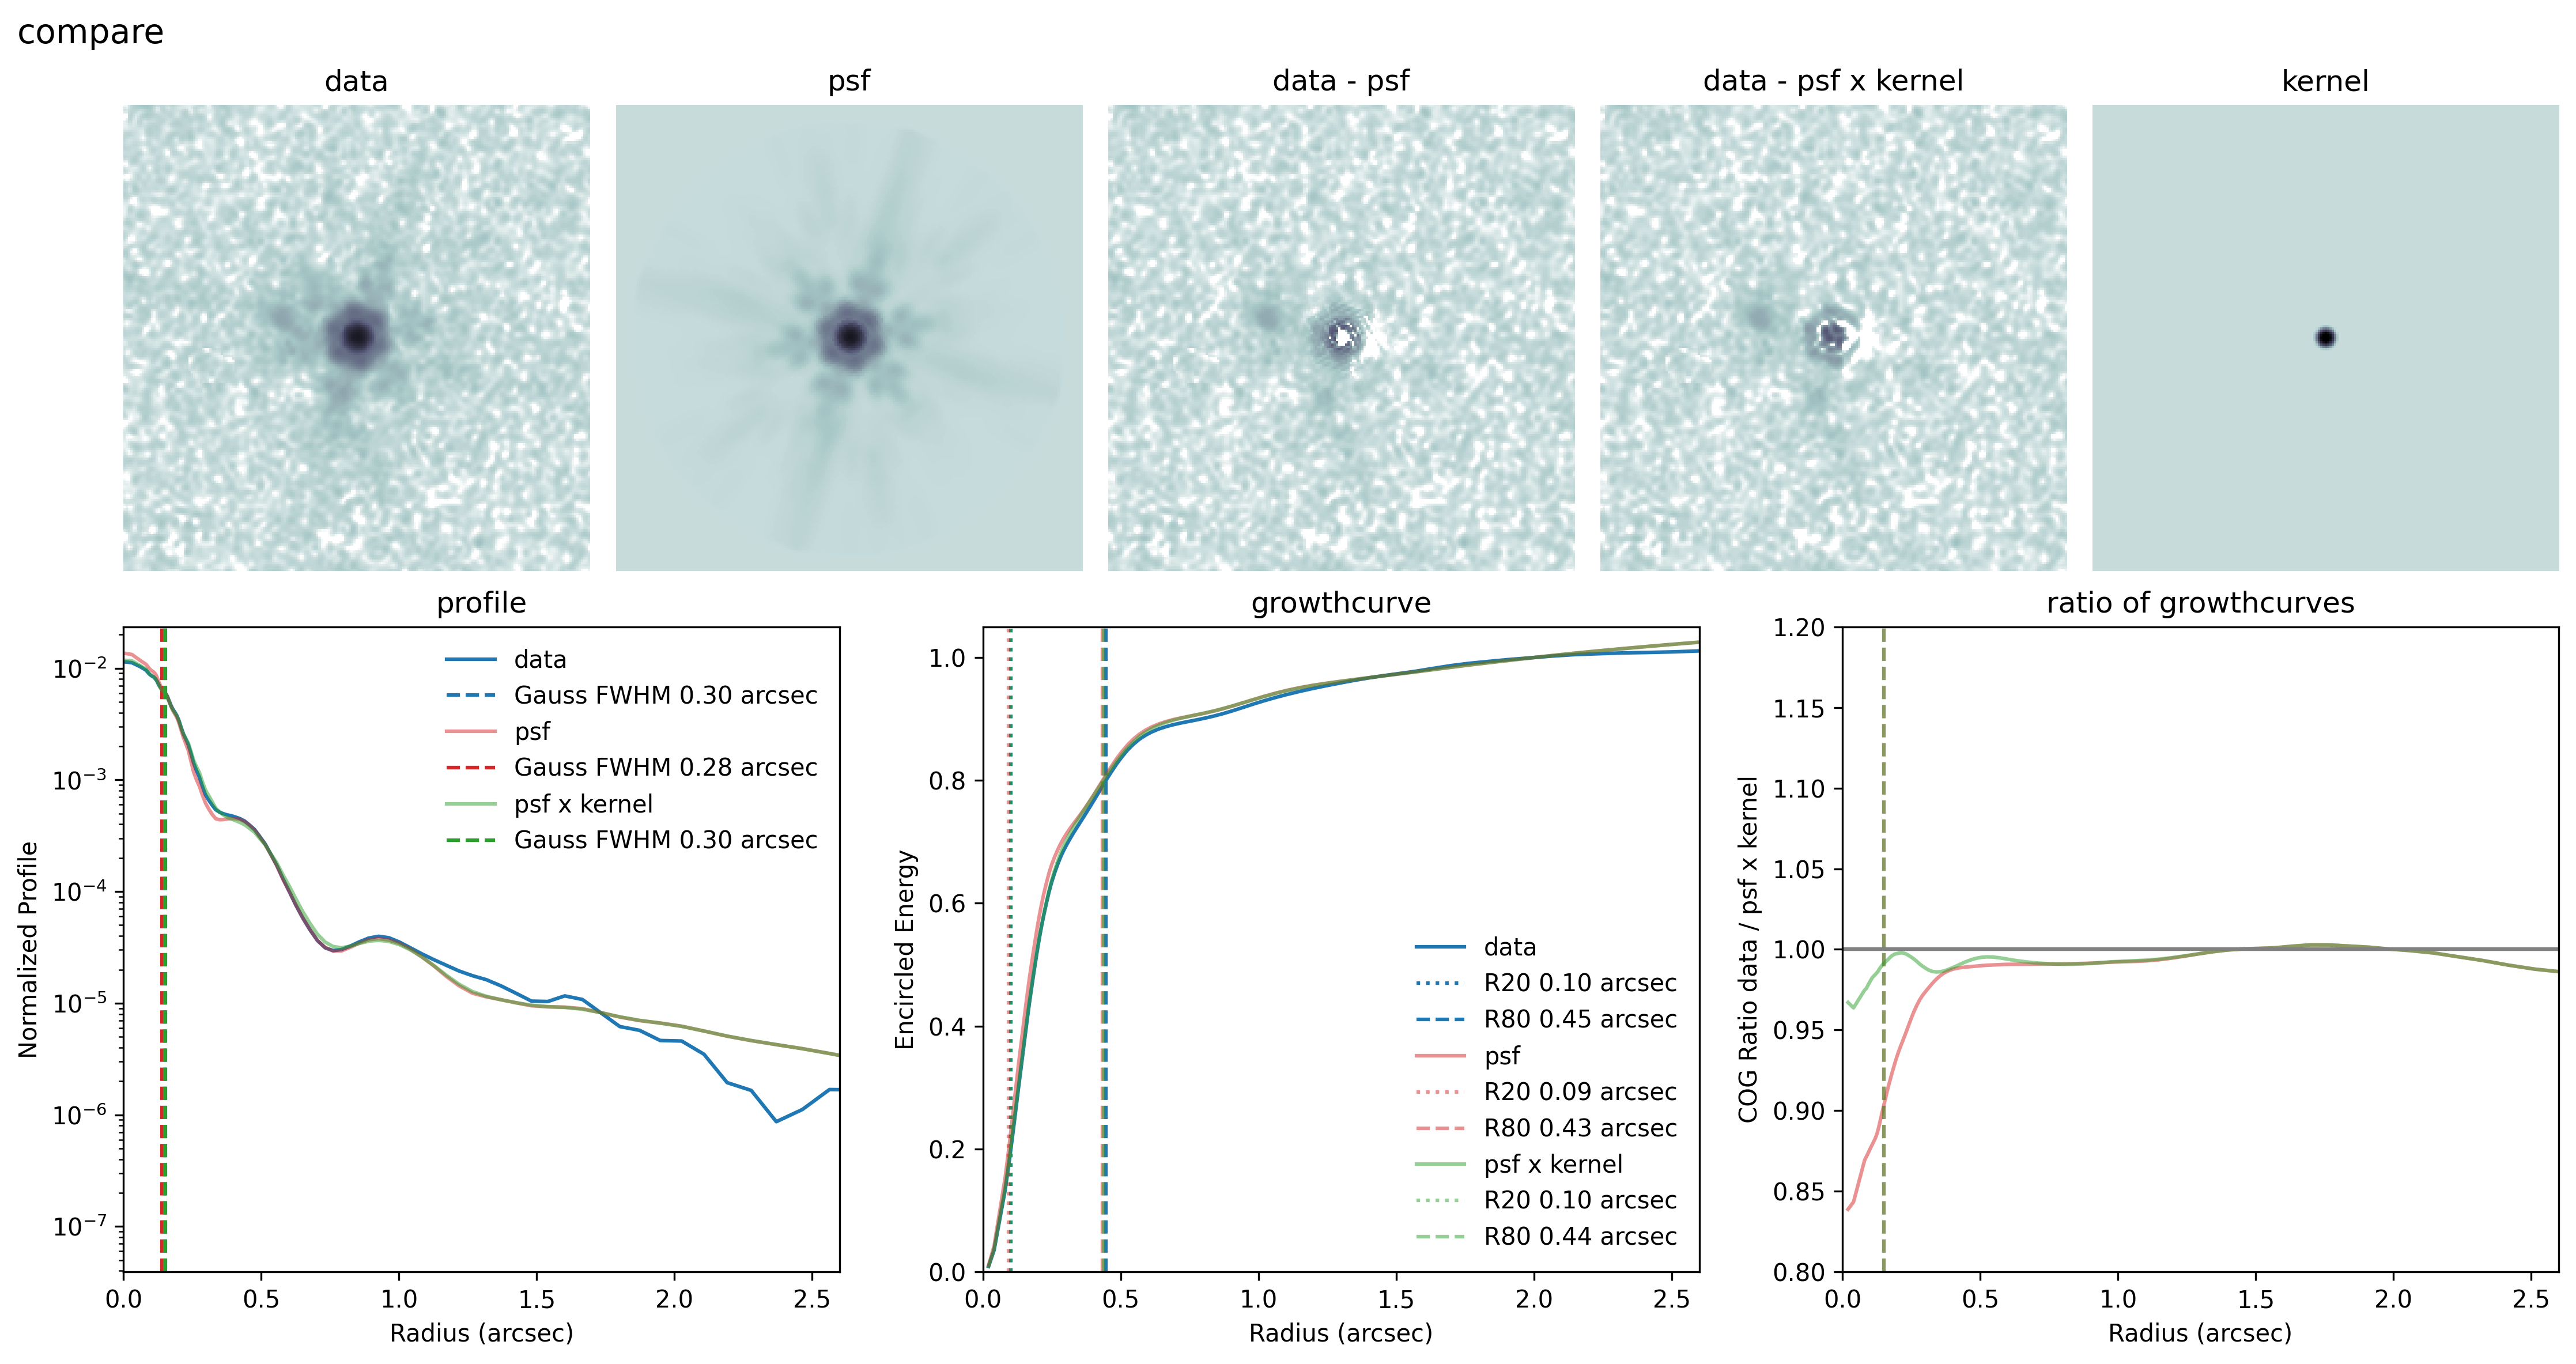

In [5]:
# fit a gaussian basis to the convolution kernel in FFT space
# this requires registration of basis, cutouts, psfs to be perfect
basis = utils.multi_gaussian_basis([0.5, 1.0, 2.0, 3.0, 4.0, 5.0], cut_sci.data.shape[0])
kernel, coeffs = utils.fit_kernel_fourier(psf_data, cut_sci.data, basis, method="nnls")

compare_psf_to_star(cut_sci.data, psf_data, weight=cut_wht.data, kernel=kernel, 
                    Rnorm=2.0, pixel_scale=dpsf.driz_pscale, to_file="compare.png")


## Now for all stars in image in F444W and F770W



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Processing filter: F444W, regex: UDS_NRC.._F444W_OS4_GRID25, fwhm_max: 2.6
Measuring inverse variance map...
Convolving with kernel size 4 pixels
Detecting sources...
Dilating segmentation map with size 2
Pixel scale: 0.04 arcsec/pixel
found 1041 sources
kept 6 point-like sources
Processing filter: F770W, regex: UDS_MIRI_F770W_OS4_GRID9, fwhm_max: 5.0
Measuring inverse variance map...
Convolving with kernel size 4 pixels
Detecting sources...
Dilating segmentation map with size

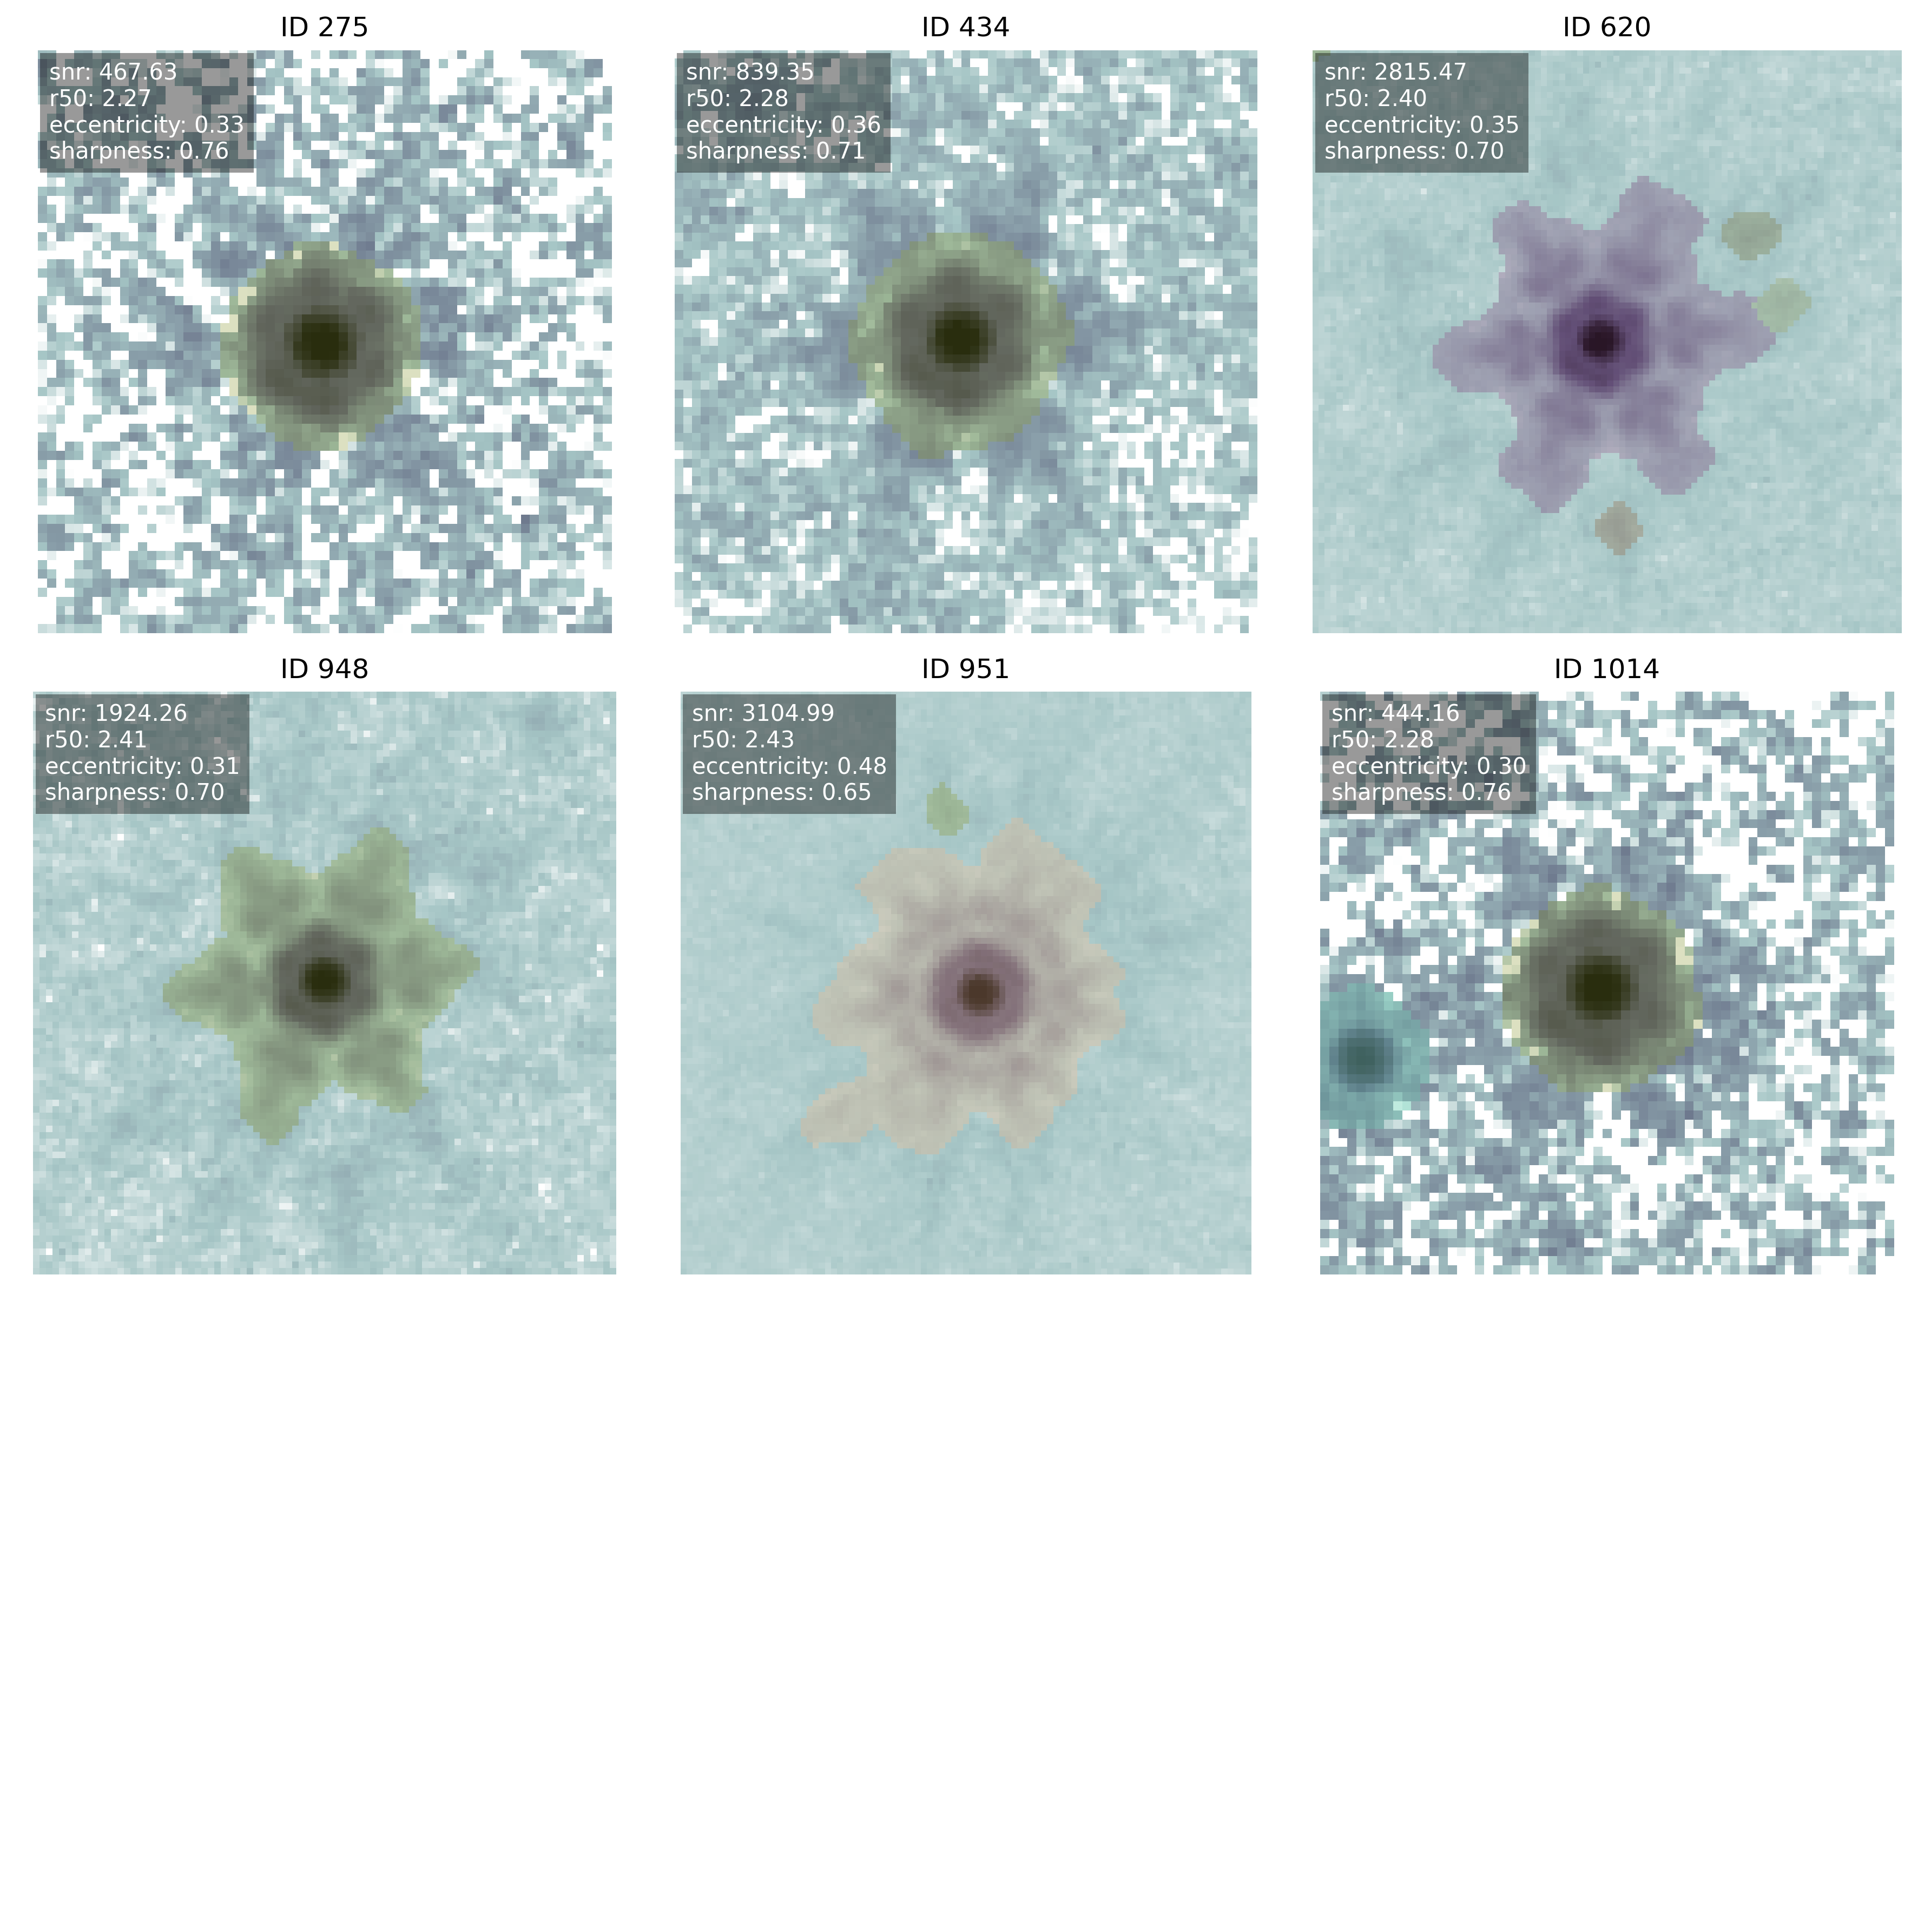

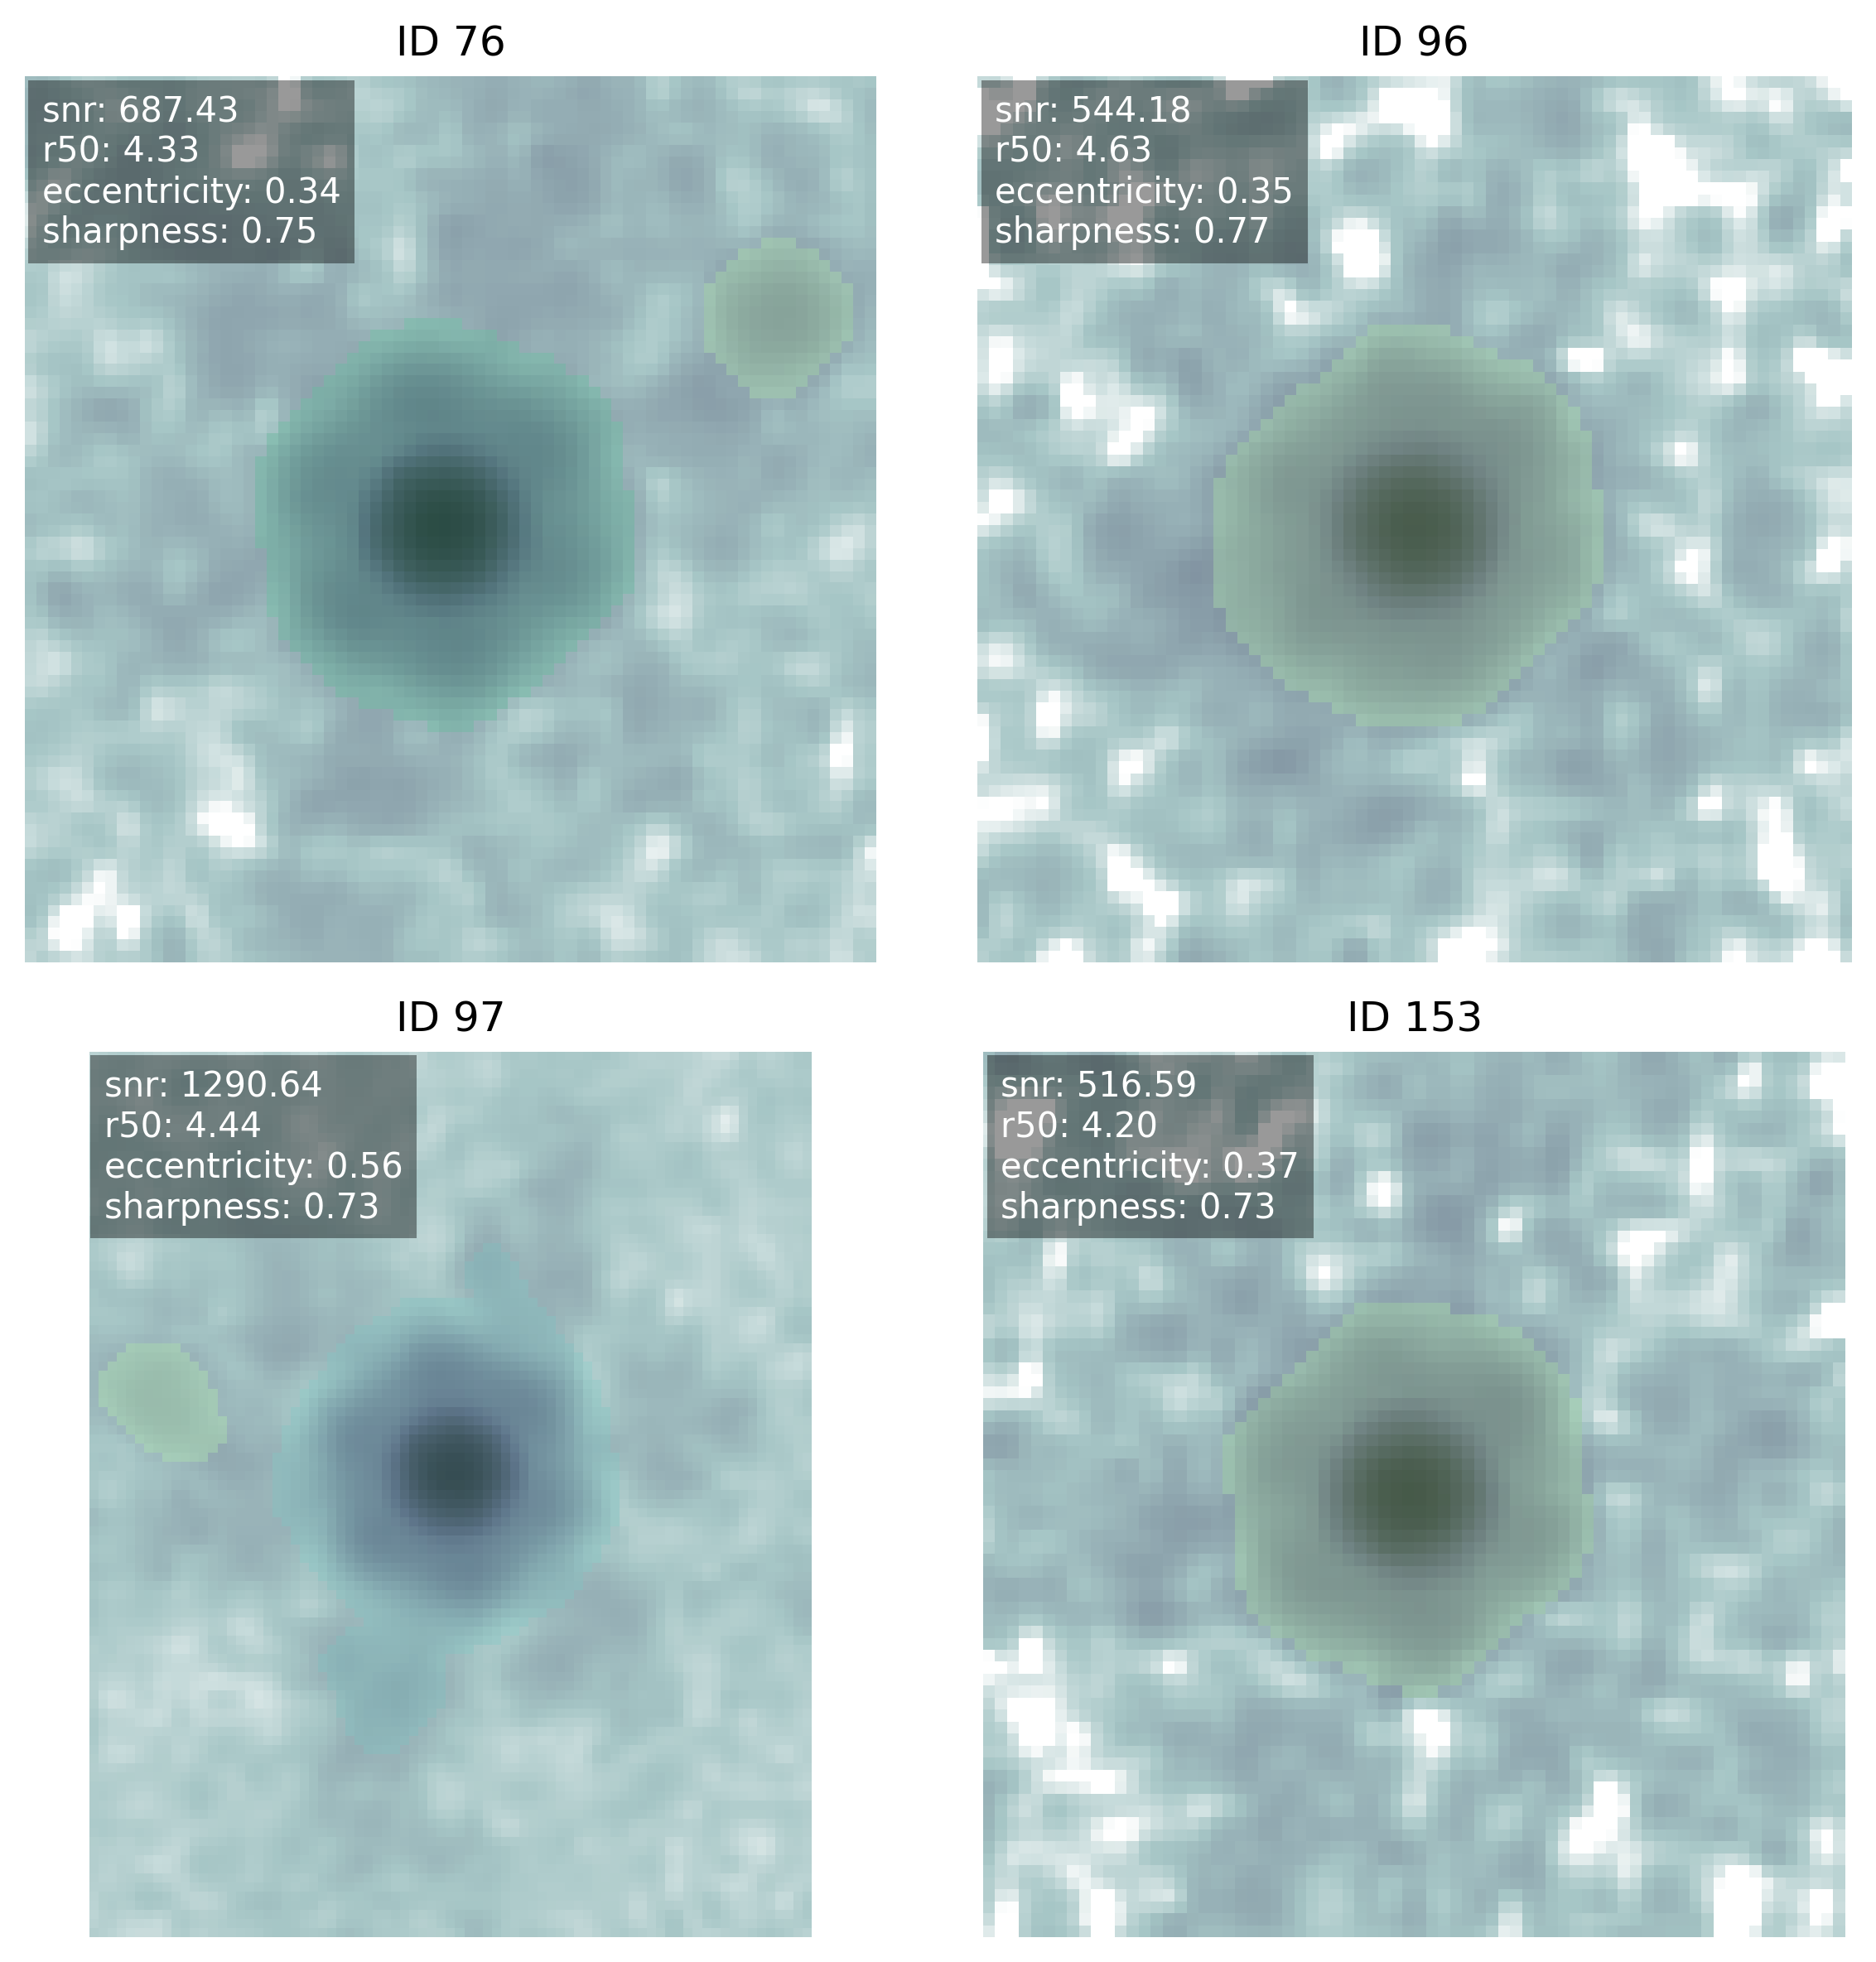

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from astropy.nddata import Cutout2D

from mophongo.psf import DrizzlePSF
from mophongo.catalog import Catalog
from mophongo.utils import compare_psf_to_star, gaussian
from mophongo.psf_map import PSFRegionMap


# NRC.. filter_regex will match all detectors A1-5, B1-5 etc for NIRCam filter, used in DrizzlePSF 
filters = [('F444W', 'UDS_NRC.._F444W_OS4_GRID25', 2.5, None), 
           ('F770W', 'UDS_MIRI_F770W_OS4_GRID9', 4.5, gaussian((9,9), fwhm = 3.3))]

suffix = ''
stars_dir = 'stars/'
base = f'../data/uds-large'
outdir = base 

Rnorm = 2.0  # in arcsec
fit_kernel = False # fit sum of gaussian kernel in Fourier space
verbose = False

for filt, filter_regex, fwhm_max, kernel in filters:
    print(f"Processing filter: {filt}, regex: {filter_regex}, fwhm_max: {fwhm_max}")
    root = f'{base}-{filt.lower()}'

    # load the PSF region map and the drizzle image
    prm  = PSFRegionMap.from_geojson(root+'_psf.geojson')
    shape = prm.psfs.shape[1:]

    # load PSF drizzler
    dpsf = DrizzlePSF(driz_image=root+'_sci.fits')
    dpsf.epsf_obj.load_jwst_stdpsf(local_dir='../data/PSF/', filter_pattern=filter_regex, verbose=verbose)

    # create a catalog to find stars
    params = {"kernel_size": 4, "detect_threshold": 3.0, "detect_npixels": 10, "deblend_mode": None}    
    cat = Catalog.from_fits(root+'_sci.fits', root+'_wht.fits', params=params, estimate_ivar=True)
    cat.cutouts = cat.catalog.make_cutouts(shape,fill_value=0)
    pscale = cat.wcs.proj_plane_pixel_scales()[0].value * 3600 
    print(f"Pixel scale: {pscale:.2f} arcsec/pixel")

    # select stars
    stars, idx = cat.find_stars(snr_min=300, r50_max=fwhm_max, eccen_max=0.7, sharp_lohi=(0.1,1))
    stars_cutouts = [cat.cutouts[j] for j in idx]

    # write catalog and image stamps
    os.makedirs(base / stars_dir, exist_ok=True)
    stars.write(stars_dir+f'stars_{filt}.csv', overwrite=True)   
    nxfig = int(np.ceil(np.sqrt(len(stars))))
    fig,ax = plt.subplots(nxfig, nxfig, figsize=(nxfig*4, nxfig*4))
    for a in ax.flatten(): a.set_axis_off()
    for cid, a in zip(stars['id'], ax.flatten()):
        cat.show_stamp(cid,keys=['snr','r50','eccentricity','sharpness'],ax=a, cmap='gray', alpha=0.3)
    fig.tight_layout()
    fig.savefig(stars_dir+f'stars_stamps_{filt}.png', dpi=300)

    # loop over stars and compare to local PSF 
    for star, star_cutout in zip(stars, stars_cutouts):
        if suffix != '':
            psf_data = prm.get_psf(star['ra'], star['dec'])
        else:
            pos_drz, _, _ = dpsf.register(star['ra'], star['dec'], filter_regex, size=15, verbose=verbose)

            cut_sci, cat_wht = dpsf.get_driz_cutout(star['ra'], star['dec'], cutout_data=[cat.sci, cat.wht], 
                                                    size=shape[0], recenter=True)
            psf_data = dpsf.get_psf(ra=pos_drz[0], dec=pos_drz[1],filter=filter_regex, wcs_slice=cut_sci.wcs,
                                    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'])

        compare_psf_to_star(cut_sci.data, psf_data, weight=cat_wht.data, 
                            Rnorm=Rnorm, pixel_scale=pscale, fit_kernel=fit_kernel, kernel=kernel,
                            to_file=f"{stars_dir}star_{star['id']}_{filt}"+suffix+".png",
                            register_psf=False)

 